## Testing a Gaussian mixture model unsupervised classifier in Kakadu (starting with Field Island)

In [1]:
%matplotlib inline
import numpy as np
import datacube
import matplotlib.pyplot as plt

In [2]:
dc = datacube.Datacube(config='radar.conf')

#section of coast south of Field Island
# x=(132.33,132.39), y=(-12.25,-12.22)

#first get Field Island (index 13) from the wetlands shapefile
import fiona
from datacube.utils import geometry

#open the shapefile with all the Ramsar wetlands
shp_path='/g/data/r78/rjd547/Ramsar_Wetlands/shapefiles/Ramsar_exploded3.shp'
shapes=fiona.open(shp_path,'r')

crs=geometry.CRS(shapes.crs_wkt)

field_island=shapes[13]
FI_poly=field_island['geometry']
geom=geometry.Geometry(FI_poly,crs=crs)

In [3]:
#define the time period
qtime = ('2016-09-01', '2019-06-01')

query = {'geopolygon': geom,
         'time': qtime
         }

In [4]:
#import the module with the denoise/despeckle functions
import radar_functions as rf

In [86]:
import rasterio.features

#load the raw SAR scenes
sardata = dc.load(product='s1_gamma0_scene_v2', group_by='solar_day', output_crs='EPSG:3577',resolution=(25,25), **query)

#Denoise and mask the radar data with the actual polygon - it will have been returned as a rectangle
sardata=sardata.where(sardata!=0)
clean=rf.denoise(sardata)
mask = rasterio.features.geometry_mask([geom.to_crs(sardata.geobox.crs)for geoms in [geom]],
                                           out_shape=sardata.geobox.shape,
                                           transform=sardata.geobox.affine,
                                           all_touched=False,
                                           invert=False)
clean=clean.where(~mask)

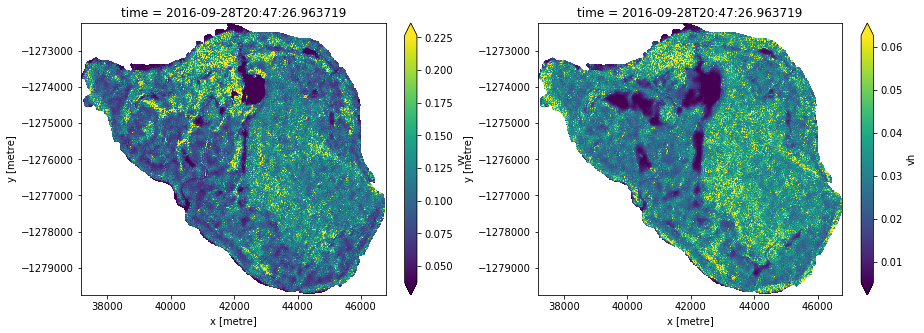

In [87]:
#take some sample image to do clusters with - doesn't really matter which one
fig,ax=plt.subplots(1,2,figsize=(15,5))
plt.sca(ax[0])
clean.isel(time=0).vv.plot(robust=True)
plt.sca(ax[1])
clean.isel(time=0).vh.plot(robust=True)

In [22]:
#fit the GMM

import radar_gmm as rg

gmm = rg.fit_gmm(clean.isel(time=0),n_components=4)
kmm = rg.fit_kmeans(clean.isel(time=10),n_components=4)

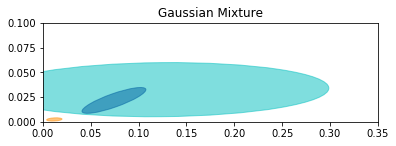

In [20]:
#plot the mixture components
rg.plot_results(gmm.means_,gmm.covariances_,0,'Gaussian Mixture')

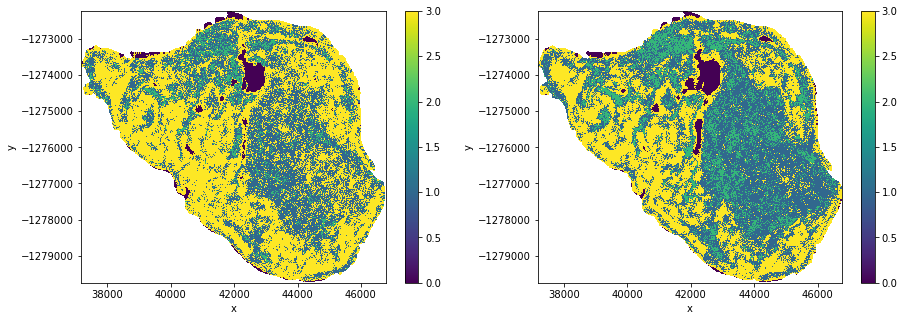

In [366]:
#plot the clusters for the training image and another unseen image
fig,ax = plt.subplots(1,2,figsize=(15,5))
plt.sca(ax[0])
rg.plot_gmm_classes(clean.isel(time=0),kmm,vmin=0)
plt.sca(ax[1])
rg.plot_gmm_classes(clean.isel(time=10),kmm)

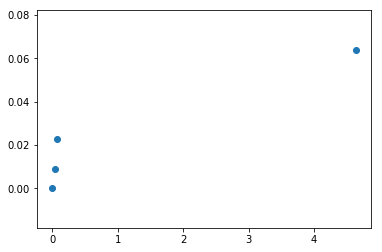

In [14]:
plt.scatter(*kmm.cluster_centers_.transpose())

In [16]:
kmm.cluster_centers_[2]

array([4.63316449, 0.0637677 ])

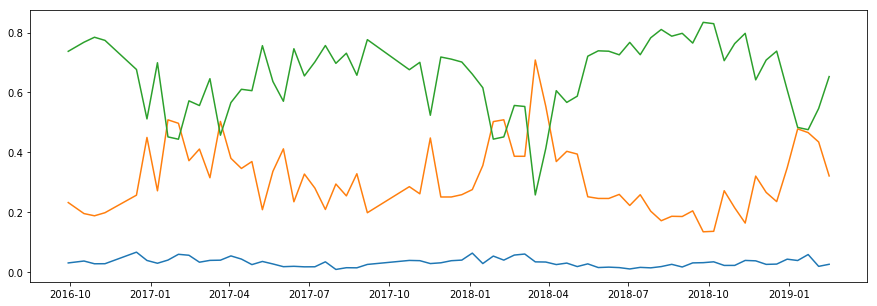

In [328]:
#plot timeseries of class predictions of the GMM
#(y axis is normalised to the number of pixels)
#plot method also returns t and y values for the plot
fig,ax = plt.subplots(1,1,figsize=(15,5))
t,ts = rg.plot_gmm_timeseries(clean,kmm)

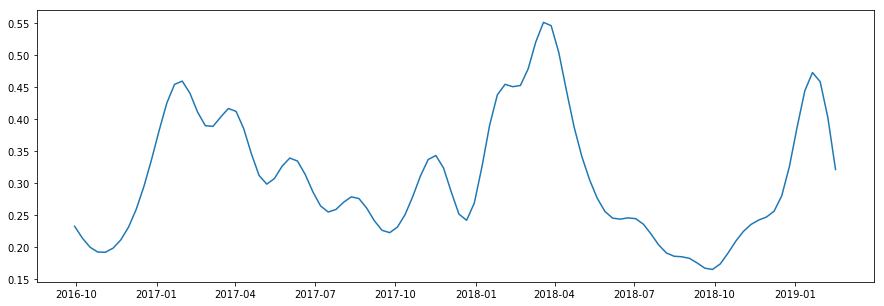

In [329]:
#observe seasonal changes by applying a low-pass filter to the spiky data
#Filter the signal with an order 4 Butterworth low-pass filter
from scipy import signal
from scipy import interpolate
import datetime

#interpolate onto an even grid before filtering
et = np.linspace(float(t[0]),float(t[-1]),num=100)

#can change the array index for ts to change the GMM class to be plotted 
ip = interpolate.interp1d([float(time) for time in t],ts[:,1])

evensignal = ip(et)

#the built-in resampler does weird things if the timesteps aren't even
#evensignal,et = signal.resample(ts[:,3],50,t=t.astype(float).to_masked_array())
#filter (forwards and backwards to avoid filter lag)
b,a = signal.butter(4,0.3)
filtsig = signal.filtfilt(b,a,evensignal)

fig,ax = plt.subplots(1,1,figsize=(15,5))

#put the float times back into readable UTC datetimes
plttime = [datetime.datetime.fromtimestamp(tstamp/1e9) for tstamp in et]
plt.plot(plttime,filtsig)

In [330]:
#load up another nearby region in Kakadu to see if the model works there
#too (do not retrain the model, this is a test of generalisation)
query_m = {
    'y' : (-12.55,-12.50),
    'x' : (131.65,131.70),
    'time' : qtime,
    'crs': 'EPSG:4326'
    
}

sardata_m = dc.load(product='s1_gamma0_scene_v2', group_by='solar_day', output_crs='EPSG:3577',resolution=(25,25), **query_m)

#Denoise and mask the radar data with the actual polygon - it will have been returned as a rectangle
sardata_m=sardata_m.where(sardata_m!=0)
clean_m=rf.denoise(sardata_m)

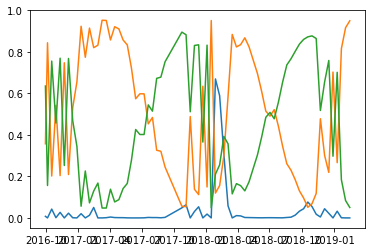

In [331]:
t,ts=rg.plot_gmm_timeseries(clean_m,kmm)

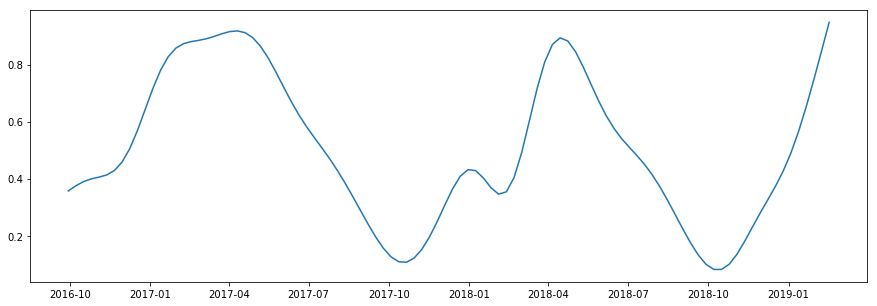

In [333]:
#observe seasonal changes by applying a low-pass filter to the spiky data
#Filter the signal with an order 4 Butterworth low-pass filter
from scipy import signal
from scipy import interpolate
import datetime

#interpolate onto an even grid before filtering
et = np.linspace(float(t[0]),float(t[-1]),num=100)

#can change the array index for ts to change the GMM class to be plotted 
ip = interpolate.interp1d([float(time) for time in t],ts[:,1])

evensignal = ip(et)

#the built-in resampler does weird things if the timesteps aren't even
#evensignal,et = signal.resample(ts[:,3],50,t=t.astype(float).to_masked_array())
#filter (forwards and backwards to avoid filter lag)
b,a = signal.butter(4,0.2)
filtsig = signal.filtfilt(b,a,evensignal)

fig,ax = plt.subplots(1,1,figsize=(15,5))

#put the float times back into readable UTC datetimes
plttime = [datetime.datetime.fromtimestamp(tstamp/1e9) for tstamp in et]
plt.plot(plttime,filtsig)

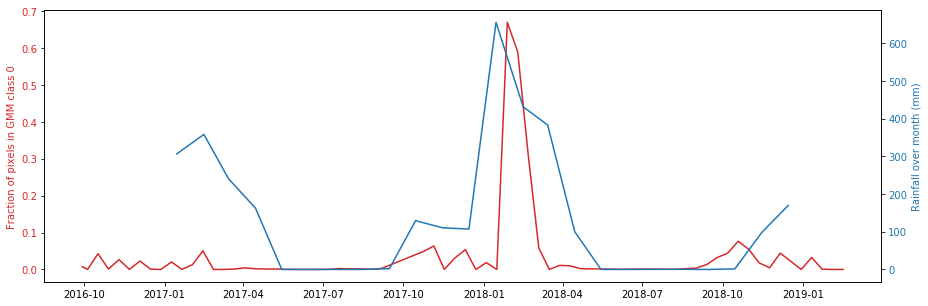

In [334]:
#2017-18 monthly rainfall at Jabiru airport sourced from BoM
rain = np.array([306.6,358.2,241.0,162.4,0.0,0.0,0.0,0.0,2.0,129.4,110.4,107.2,655.4,431.4,383.2,100.0,0.0,0.0,0.2,0.4,0.0,1.4,98.6,169.6])

startmonth = datetime.date(2017,1,15)
months = [startmonth.replace(month=i) for i in range(1,13)]
m2 = [month.replace(year=2018) for month in months]
for m in m2:
    months.append(m)

    
fig,ax = plt.subplots(1,1,figsize=(15,5))

color='tab:red'
ax.set_ylabel('Fraction of pixels in GMM class 0',color=color)
ax.tick_params(axis='y', labelcolor=color)
plt.plot(t,ts[:,0],color=color)

ax2=ax.twinx()
color='tab:blue'
ax2.set_ylabel('Rainfall over month (mm)',color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.plot(months, rain,color=color)
plt.show()


In [2]:
fig,ax = plt.subplots(1,1,figsize=(15,5))

color='tab:red'
ax.set_ylabel('Fraction of pixels in GMM class 0',color=color)
ax.tick_params(axis='y', labelcolor=color)
plt.plot(t,ts[:,2],color=color)

ax2=ax.twinx()
color='tab:blue'
ax2.set_ylabel('Rainfall daily (mm)',color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.plot(rain.time, rain.rainfall,color=color)
plt.show()


NameError: name 'plt' is not defined

In [164]:
#can we relate the classes to what is actually happening on the ground?
dcO=datacube.Datacube()

import sys
sys.path.append('/g/data/r78/rlt118/dea-notebooks/10_Scripts/')
import DEADataHandling

#set cloudmasking threshold and load landsat nbart data
landsat_masked_prop = 0.8 # 0.90

#set the masking dictionary up for science analysis: remove saturated and uncontiguous values
ls578_ds = DEADataHandling.load_clearlandsat(dc=dcO, query=query, product='nbart', 
                mask_dict=dict(cloud_acca='no_cloud',
                 cloud_shadow_acca='no_cloud_shadow',
                 cloud_shadow_fmask='no_cloud_shadow',
                 cloud_fmask='no_cloud',
                 blue_saturated=False,
                 green_saturated=False,
                 red_saturated=False,
                 nir_saturated=False,
                 swir1_saturated=False,
                 swir2_saturated=False,
                 contiguous=True),
                mask_pixel_quality=True,
                masked_prop=landsat_masked_prop)


Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls8
    Loading 37 filtered ls8 timesteps
Returning ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


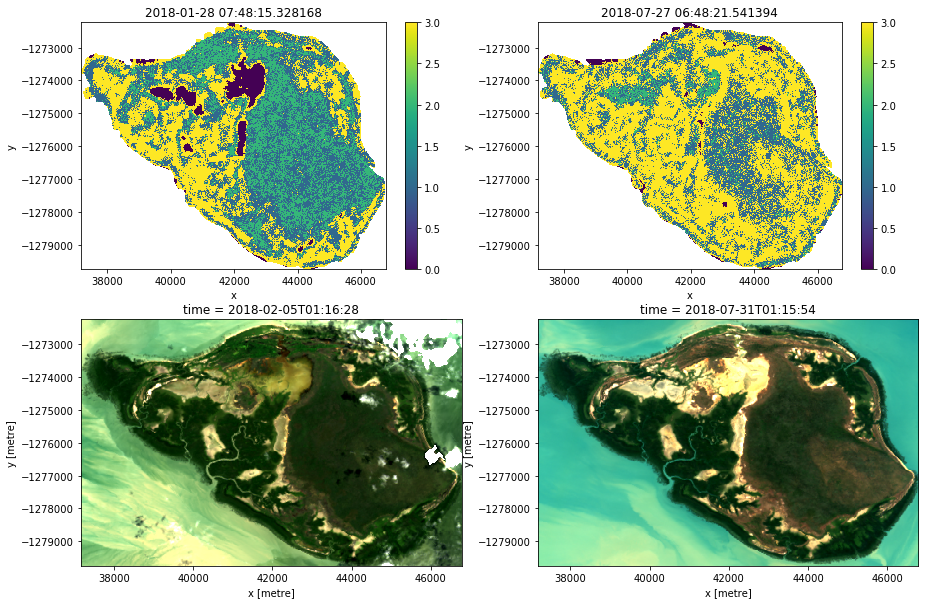

In [367]:
import DEAPlotting

def stringfromtime(timeobj):
    return str(datetime.datetime.fromtimestamp(timeobj.item()/1e9))

plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
rg.plot_gmm_classes(clean.isel(time=35),kmm)
plt.title(stringfromtime(clean.isel(time=35).time))

plt.subplot(2,2,2)
rg.plot_gmm_classes(clean.isel(time=50),kmm)
plt.title(stringfromtime(clean.isel(time=50).time))

ax=plt.subplot(2,2,3)
DEAPlotting.rgb(ls578_ds, index=14, bands=['red', 'green', 'blue'],ax=ax,size=None)

ax=plt.subplot(2,2,4)
DEAPlotting.rgb(ls578_ds, index=24, bands=['red', 'green', 'blue'],ax=ax,size=None)


In [116]:
ls578_ds.isel(time=2)

<xarray.Dataset>
Dimensions:          (x: 222, y: 219)
Coordinates:
    time             datetime64[ns] 2016-10-29T01:17:21.500000
  * y                (y) float64 -1.319e+06 -1.319e+06 ... -1.324e+06 -1.324e+06
  * x                (x) float64 -3.871e+04 -3.869e+04 ... -3.321e+04 -3.319e+04
Data variables:
    coastal_aerosol  (y, x) float64 567.0 556.0 543.0 555.0 ... nan nan nan nan
    blue             (y, x) float64 482.0 471.0 464.0 488.0 ... nan nan nan nan
    green            (y, x) float64 688.0 684.0 693.0 777.0 ... nan nan nan nan
    red              (y, x) float64 539.0 520.0 517.0 564.0 ... nan nan nan nan
    nir              (y, x) float64 2.427e+03 2.516e+03 2.668e+03 ... nan nan
    swir1            (y, x) float64 2.042e+03 1.985e+03 1.952e+03 ... nan nan
    swir2            (y, x) float64 1.124e+03 1.051e+03 1.003e+03 ... nan nan
    data_perc        (y, x) float64 0.8047 0.8047 0.8047 0.8047 ... nan nan nan
Attributes:
    crs:      EPSG:3577

In [196]:
mean_vh=clean.vh.mean(dim=['x','y'])

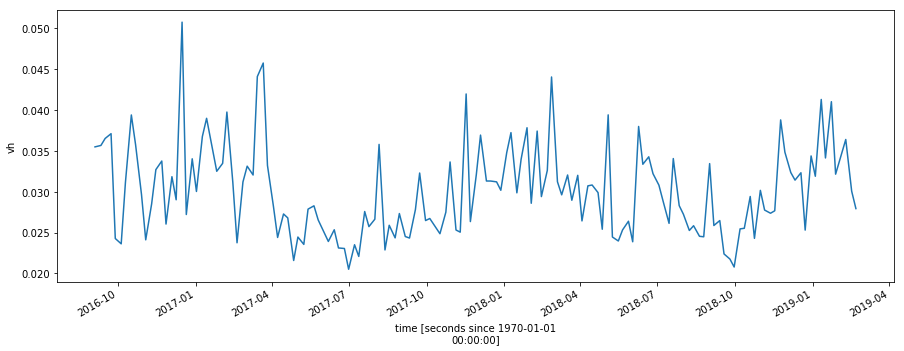

In [296]:
plt.figure(figsize=(15,5))
mean_vh.plot()

In [286]:
import imp
imp.reload(rg)

<module 'radar_gmm' from '/g/data1a/r78/rlt118/dea-notebooks/radar_gmm.py'>

In [337]:
import RainfallTools

In [339]:
#gridded BoM data
rain=RainfallTools.load_rainfall(query)

These rainfall grids have been realigned by the load_rainfall function - if you think this   may be incorrect then check your data and metadata then contact BDunn or VNewey


In [356]:
rain=rain.mean(dim=['latitude','longitude'])

## Try something down south instead of a tropical wetland

In [2]:
#get hattah lakes box (the polygon does not include the shore areas which will have lots of nice vegetation)
#polygons 16-27

dc = datacube.Datacube(config='radar.conf')

#open the shapefile with all the Ramsar wetlands
import fiona
from datacube.utils import geometry

shp_path = '/g/data/r78/rjd547/Ramsar_Wetlands/shapefiles/Ramsar_exploded3.shp'
shapes = fiona.open(shp_path,'r')

crs = geometry.CRS(shapes.crs_wkt)

geoms=[]

for lake_shape in shapes[42:57]:
    lake_poly = lake_shape['geometry']
    geom = geometry.Geometry(lake_poly,crs=crs)
    geoms.append(geom)





/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/fiona/collection.py:336: FionaDeprecationWarning: Collection slicing is deprecated and will be disabled in a future version.
  return self.session.__getitem__(item)


In [3]:
total_geom=geometry.unary_union(geoms)

#define the time period
qtime = ('2016-09-01', '2017-12-31')

query = {'geopolygon': total_geom,
         'time': qtime
         }

#import the module with the denoise/despeckle functions
import radar_functions as rf

In [4]:
import rasterio.features

import xarray as xr
def filter_by_coverage(data):
    invalid_fracs = np.isnan(data.to_array()[0]).groupby('time').mean(dim=xr.ALL_DIMS).values
    zero_fracs = (data.to_array()[0]<1e-5).groupby('time').mean(dim=xr.ALL_DIMS).values
    valid_check = (invalid_fracs + zero_fracs) < 0.5   
    data = data.isel(time=valid_check)
    return data.where(data!=0)


#load the raw SAR scenes
sardata = dc.load(product='s1_gamma0_scene_v2', group_by='solar_day', output_crs='EPSG:3577',resolution=(25,25), **query)

#Denoise and mask the radar data with the actual polygon - it will have been returned as a rectangle
sardata=sardata.where(sardata!=0)
clean=rf.denoise(sardata)
clean = filter_by_coverage(clean)
mask = rasterio.features.geometry_mask([geoms.to_crs(sardata.geobox.crs)for geoms in [total_geom]],
                                            out_shape=sardata.geobox.shape,
                                            transform=sardata.geobox.affine,
                                            all_touched=False,
                                            invert=False)
clean=clean.where(~mask)

/g/data1a/r78/rlt118/dea-notebooks/radar_functions.py:24: RuntimeWarning: invalid value encountered in true_divide
  img_weights = img_variance / (img_variance + overall_variance)


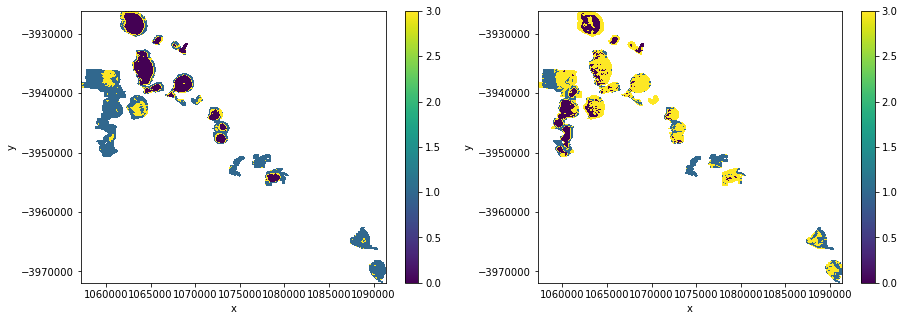

In [8]:
#plot the clusters for the training image and another unseen image
fig,ax = plt.subplots(1,2,figsize=(15,5))
plt.sca(ax[0])
rg.plot_gmm_classes(clean.isel(time=0),kmm,vmin=0)
plt.sca(ax[1])
rg.plot_gmm_classes(clean.isel(time=11),kmm)

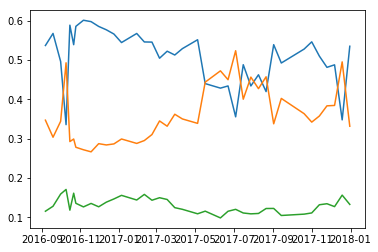

In [264]:
t,ts=rg.plot_gmm_timeseries(clean,kmm)

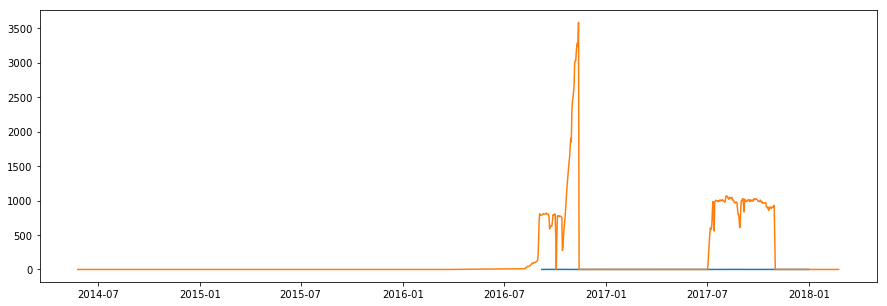

In [159]:
#observe seasonal changes by applying a low-pass filter to the spiky data
#Filter the signal with an order 4 Butterworth low-pass filter
from scipy import signal
from scipy import interpolate
import datetime

#interpolate onto an even grid before filtering
et = np.linspace(float(t[0]),float(t[-1]),num=100)

#can change the array index for ts to change the GMM class to be plotted 
ip = interpolate.interp1d([float(time) for time in t],ts[:,0])

evensignal = ip(et)

#the built-in resampler does weird things if the timesteps aren't even
#evensignal,et = signal.resample(ts[:,3],50,t=t.astype(float).to_masked_array())
#filter (forwards and backwards to avoid filter lag)
b,a = signal.butter(4,0.2)
filtsig = signal.filtfilt(b,a,evensignal)

fig,ax = plt.subplots(1,1,figsize=(15,5))

#put the float times back into readable UTC datetimes
plttime = [datetime.datetime.fromtimestamp(tstamp/1e9) for tstamp in et]


plt.plot(t,ts[:,1],flow_df['Date'],flow_df['Flow'])

In [107]:
#gridded BoM data
import sys
sys.path.append('/g/data/r78/rlt118/dea-notebooks/10_Scripts/')
import RainfallTools
rain = RainfallTools.load_rainfall(query)
rain = rain.mean(dim=['latitude','longitude'])

These rainfall grids have been realigned by the load_rainfall function - if you think this   may be incorrect then check your data and metadata then contact BDunn or VNewey


In [127]:
max(ts[:,0])

0.18824646829716568

In [139]:
#load hattah environmental flow data
import pandas as pd

df = pd.read_excel(r'hattah_flows.xlsx')

In [143]:
flow_df = df[['Hattah Lakes','Unnamed: 1']][3:]

In [157]:
flow_df = flow_df.rename(index=str,columns={'Hattah Lakes':'Date','Unnamed: 1':'Flow'})
flow_df = flow_df.replace(np.nan,0)


In [164]:
import datetime
mindate = datetime.datetime(2016,7,1,0,0,0)
#trim irrelevant dates before S1A data available
flow_df.where(flow_df['Date']>mindate,inplace=True)
flow_df.dropna(inplace=True)

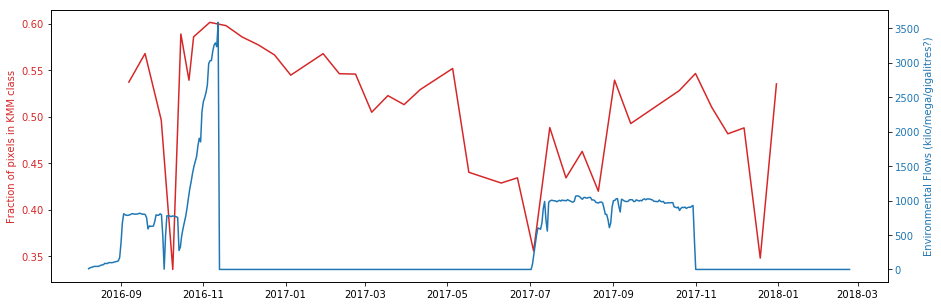

In [266]:
#plot env flows and KMM class on same axes

fig,ax = plt.subplots(1,1,figsize=(15,5))

color='tab:red'
ax.set_ylabel('Fraction of pixels in KMM class',color=color)
ax.tick_params(axis='y', labelcolor=color)
plt.plot(t,ts[:,0],color=color)

ax2=ax.twinx()
color='tab:blue'
ax2.set_ylabel('Environmental Flows (kilo/mega/gigalitres?)',color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.plot(flow_df['Date'], flow_df['Flow'],color=color)
plt.show()

In [10]:
#load optical
dcO = datacube.Datacube()

In [27]:
import sys
sys.path.append('/g/data/r78/rlt118/dea-notebooks/10_Scripts/')
import DEADataHandling
#set cloudmasking threshold and load landsat nbart data
landsat_masked_prop = 0.8 # 0.90

#set the masking dictionary up for science analysis: remove saturated and uncontiguous values
ls578_ds = DEADataHandling.load_clearlandsat(dc=dcO, query=query, product='nbart', 
                mask_dict=dict(cloud_acca='no_cloud',
                 cloud_shadow_acca='no_cloud_shadow',
                 cloud_shadow_fmask='no_cloud_shadow',
                 cloud_fmask='no_cloud',
                 blue_saturated=False,
                 green_saturated=False,
                 red_saturated=False,
                 nir_saturated=False,
                 swir1_saturated=False,
                 swir2_saturated=False,
                 contiguous=True),
                mask_pixel_quality=True,
                masked_prop=landsat_masked_prop)

Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls8
    Loading 34 filtered ls8 timesteps
Returning ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


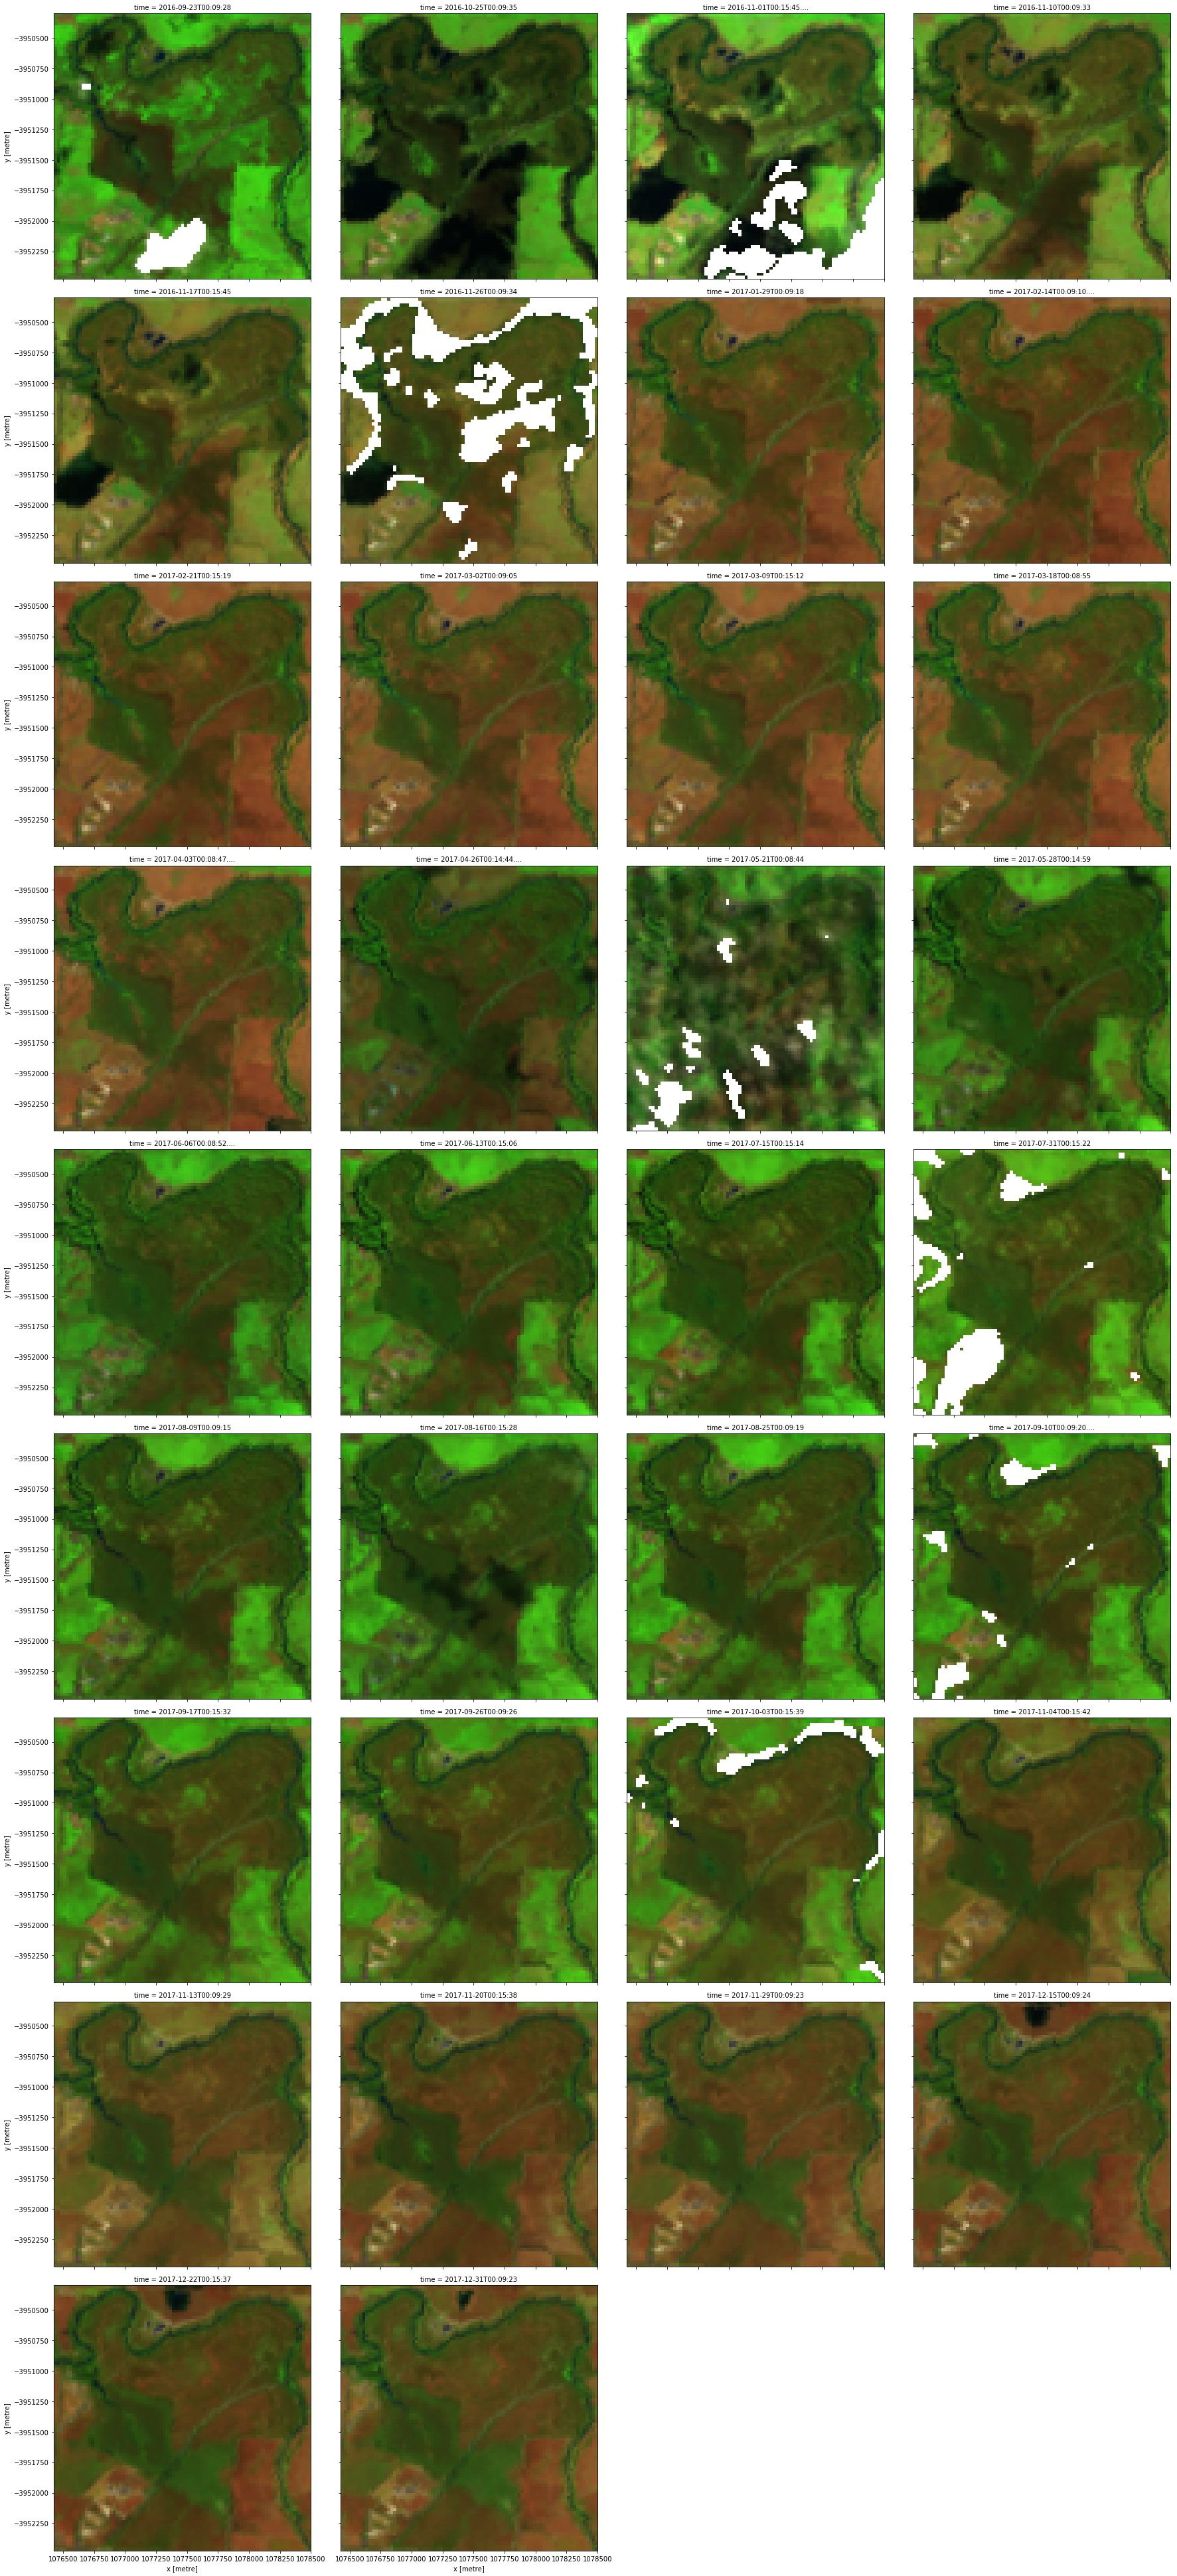

In [28]:
import DEAPlotting

DEAPlotting.rgb(ls578_ds, bands=['swir1', 'nir', 'green'], col='time',col_wrap=4,robust=False)

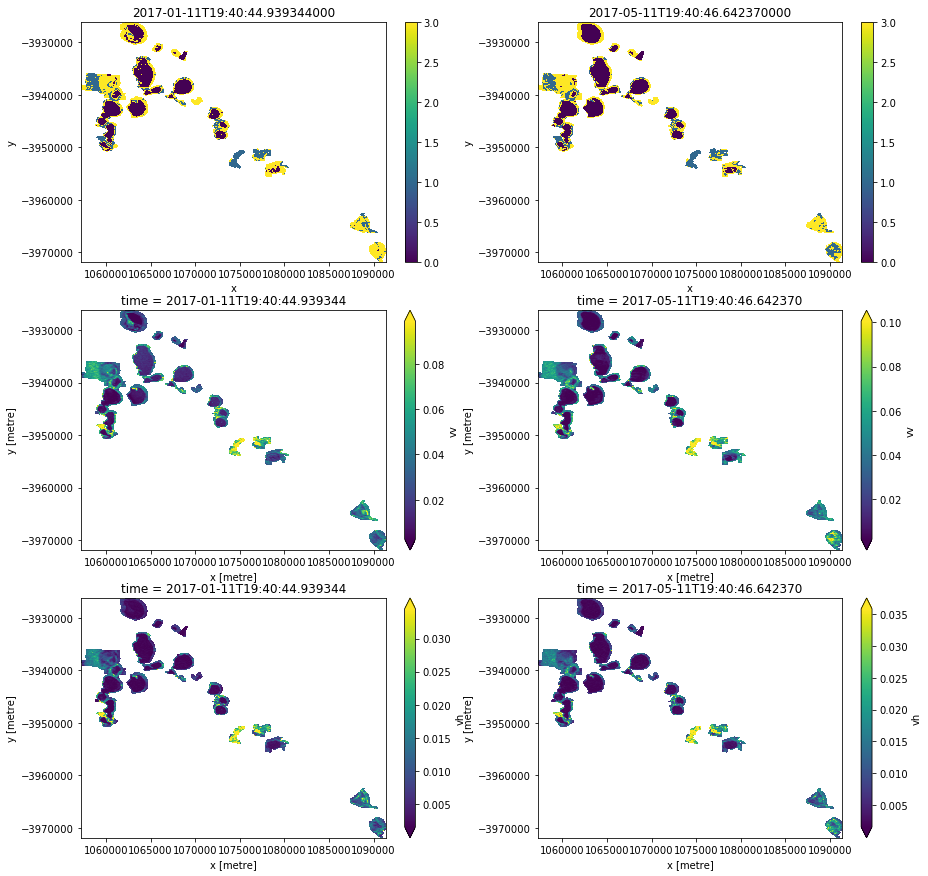

In [13]:
#plot the clusters for two radar images for comparison to optical above
def stringfromtime(timeobj):
    return str(np.datetime64(timeobj.item(),'ns'))

tind1=10
tind2=20

fig,ax = plt.subplots(3,2,figsize=(15,15))
plt.sca(ax[0,0])
rg.plot_gmm_classes(clean.isel(time=tind1),kmm,vmin=0)
plt.title(stringfromtime(clean.isel(time=tind1).time))
plt.sca(ax[0,1])
rg.plot_gmm_classes(clean.isel(time=tind2),kmm)
plt.title(stringfromtime(clean.isel(time=tind2).time))
plt.sca(ax[1,0])
clean.isel(time=tind1).vv.plot(robust=True)
plt.sca(ax[1,1])
clean.isel(time=tind2).vv.plot(robust=True)
plt.sca(ax[2,0])
clean.isel(time=tind1).vh.plot(robust=True)
plt.sca(ax[2,1])
clean.isel(time=tind2).vh.plot(robust=True)

In [24]:
#Get just one polygon so we can maybe see the veg classes from ANAE

total_geom=geoms[1]

#define the time period
qtime = ('2016-09-01', '2017-12-31')

query = {'geopolygon': total_geom,
         'time': qtime
         }

import rasterio.features

#load the raw SAR scenes
sardata = dc.load(product='s1_gamma0_scene_v2', group_by='solar_day', output_crs='EPSG:3577',resolution=(25,25), **query)

#Denoise and mask the radar data with the actual polygon - it will have been returned as a rectangle
sardata=sardata.where(sardata!=0)
clean=rf.denoise(sardata)
mask = rasterio.features.geometry_mask([total_geom.to_crs(sardata.geobox.crs)],
                                            out_shape=sardata.geobox.shape,
                                            transform=sardata.geobox.affine,
                                            all_touched=False,
                                            invert=False)
clean=clean.where(~mask)


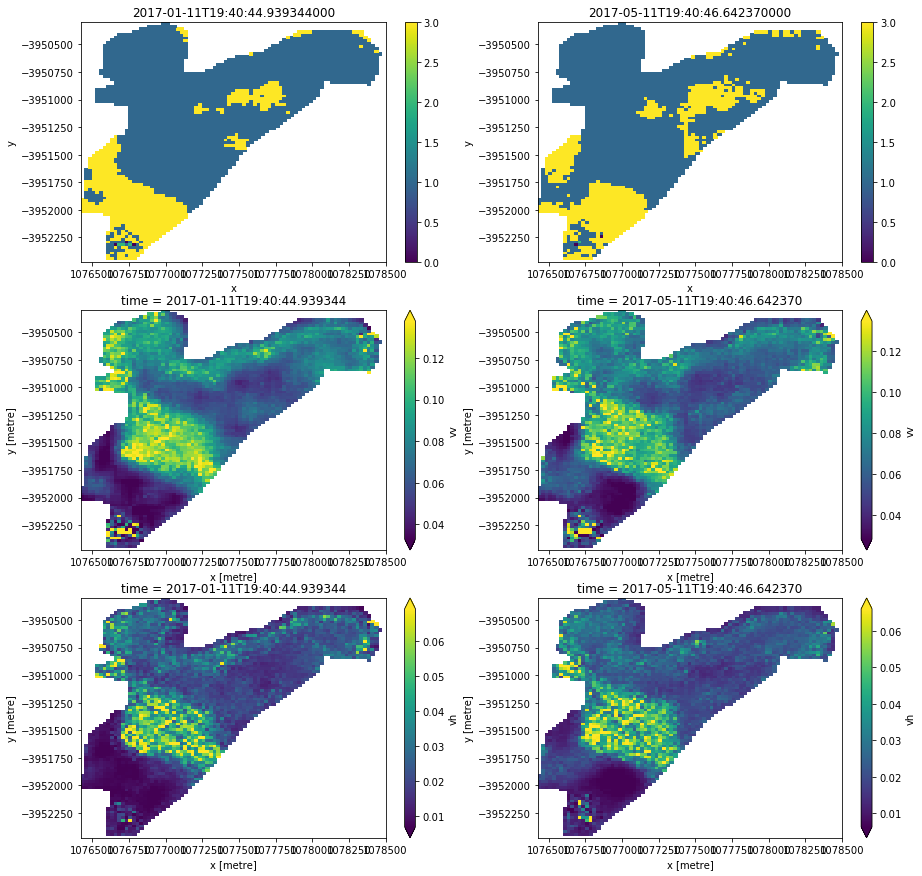

In [26]:
tind1=10
tind2=20

fig,ax = plt.subplots(3,2,figsize=(15,15))
plt.sca(ax[0,0])
rg.plot_gmm_classes(clean.isel(time=tind1),kmm,vmin=0)
plt.title(stringfromtime(clean.isel(time=tind1).time))
plt.sca(ax[0,1])
rg.plot_gmm_classes(clean.isel(time=tind2),kmm)
plt.title(stringfromtime(clean.isel(time=tind2).time))
plt.sca(ax[1,0])
clean.isel(time=tind1).vv.plot(robust=True)
plt.sca(ax[1,1])
clean.isel(time=tind2).vv.plot(robust=True)
plt.sca(ax[2,0])
clean.isel(time=tind1).vh.plot(robust=True)
plt.sca(ax[2,1])
clean.isel(time=tind2).vh.plot(robust=True)

In [245]:
timeobj = clean.isel(time=10).time
str(datetime.datetime.fromtimestamp(timeobj.item()/1e9))

'2016-12-12 06:48:45.003518'

In [251]:
np.datetime64(clean.isel(time=10).time.item(),'ns')

numpy.datetime64('2016-12-11T19:48:45.003518000')